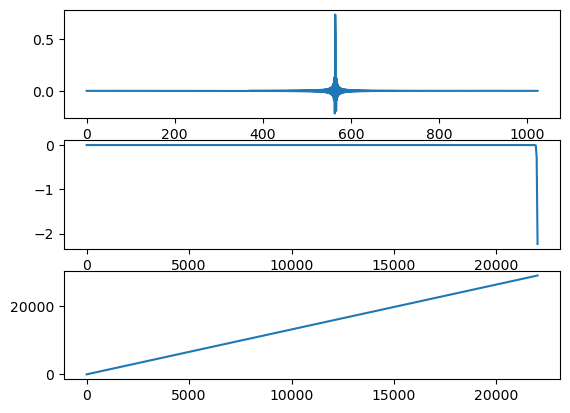

In [40]:
#%% 0. Import dependencies
import numpy as np
import torch
import torchaudio
import scipy
import xtalkdemixhelpers as xdmx
import matplotlib.pyplot as plt

CHUNK = 4 #duration of chunks of audio, in seconds, from the dataset that will be used in model training
TARGETDELAY = 1.2 #millisecond delay of training input in order to promote causal filter result of neural network training

filtmaker = xdmx.AllPassDelayFilter(LENFILTER=1024,device='cpu')
fcoefs = filtmaker(torch.tensor(TARGETDELAY))
fcoefsnp = np.copy(fcoefs.numpy())

intfiltmaker = xdmx.AllPassIntegerDelayFilter(LENFILTER=1024,device='cpu')
fintcoefs = intfiltmaker(torch.tensor(TARGETDELAY))
fintcoefsnp = np.copy(fintcoefs.numpy())



fax, H = scipy.signal.freqz(np.swapaxes(fcoefsnp,0,1), fs=44100)
fax.shape, H.shape
plt.subplot(3,1,1)
plt.plot(np.swapaxes(fcoefsnp,0,1))

plt.subplot(3,1,2)
plt.plot(fax,20*np.log10(np.abs(H)))

plt.subplot(3,1,3)
plt.plot(fax,20*np.unwrap(np.angle((H))))

/var/folders/d7/jc2lb6zs5f5b9pb1w2ms4g5h0000gn/T/ipykernel_11736/2849383670.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(fwint,20*np.log10(np.abs(Hkaisert)))


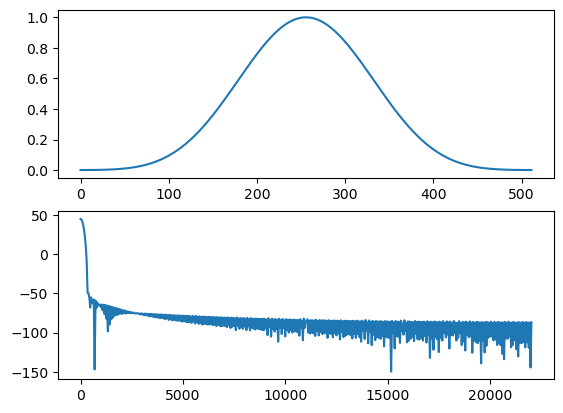

In [2]:
winkaist = torch.signal.windows.kaiser(512)
fwint, Hkaisert = scipy.signal.freqz(winkaist.numpy(),fs=44100)
plt.subplot(2,1,1)
plt.plot(winkaist)
plt.subplot(2,1,2)
plt.plot(fwint,20*np.log10(np.abs(Hkaisert)))

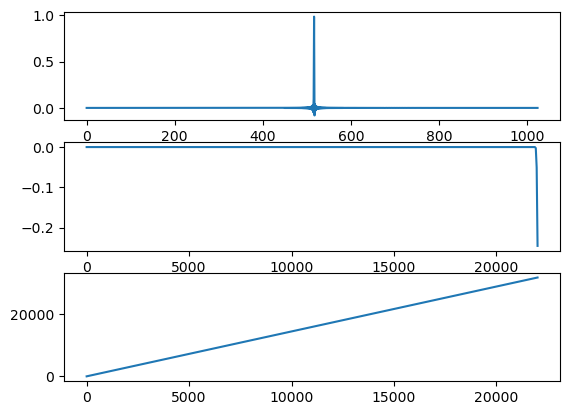

In [3]:
fax, H = scipy.signal.freqz(np.swapaxes(fcoefsnp,0,1), fs=44100)
fax.shape, H.shape
plt.subplot(3,1,1)
plt.plot(np.swapaxes(fcoefsnp,0,1))

plt.subplot(3,1,2)
plt.plot(fax,20*np.log10(np.abs(H)))

plt.subplot(3,1,3)
plt.plot(fax,20*np.unwrap(np.angle((H))))

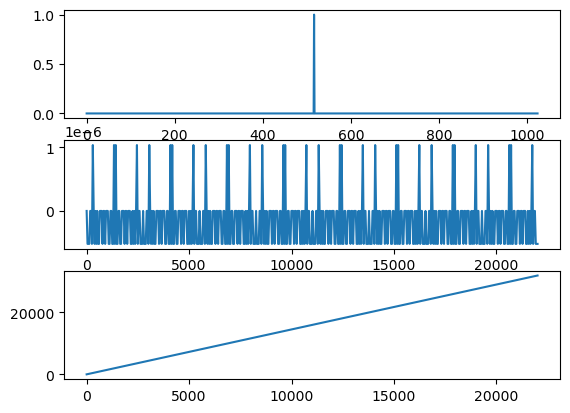

In [4]:
fax, Hint = scipy.signal.freqz(np.swapaxes(fintcoefsnp,0,1), fs=44100)
fax.shape, Hint.shape
plt.subplot(3,1,1)
plt.plot(np.swapaxes(fintcoefsnp,0,1))

plt.subplot(3,1,2)
plt.plot(fax,20*np.log10(np.abs(Hint)))

plt.subplot(3,1,3)
plt.plot(fax,20*np.unwrap(np.angle((Hint))))

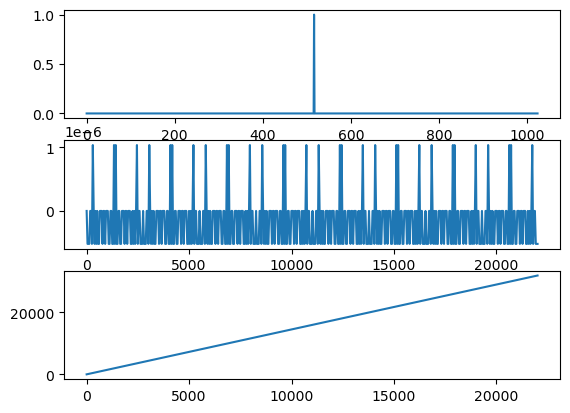

In [5]:
fax, Hint = scipy.signal.freqz(np.swapaxes(fintcoefsnp,0,1), fs=44100)
fax.shape, Hint.shape
plt.subplot(3,1,1)
plt.plot(np.swapaxes(fintcoefsnp,0,1))

plt.subplot(3,1,2)
plt.plot(fax,20*np.log10(np.abs(Hint)))

plt.subplot(3,1,3)
plt.plot(fax,20*np.unwrap(np.angle((Hint))))

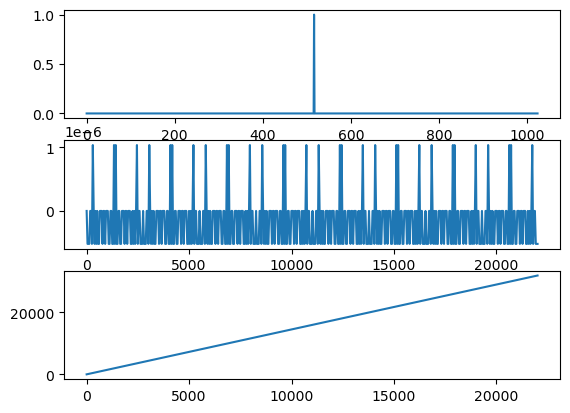

In [6]:
fax, Hint = scipy.signal.freqz(np.swapaxes(fintcoefsnp,0,1), fs=44100)
fax.shape, Hint.shape
plt.subplot(3,1,1)
plt.plot(np.swapaxes(fintcoefsnp,0,1))

plt.subplot(3,1,2)
plt.plot(fax,20*np.log10(np.abs(Hint)))

plt.subplot(3,1,3)
plt.plot(fax,20*np.unwrap(np.angle((Hint))))

delay samples = 1.7999999523162842


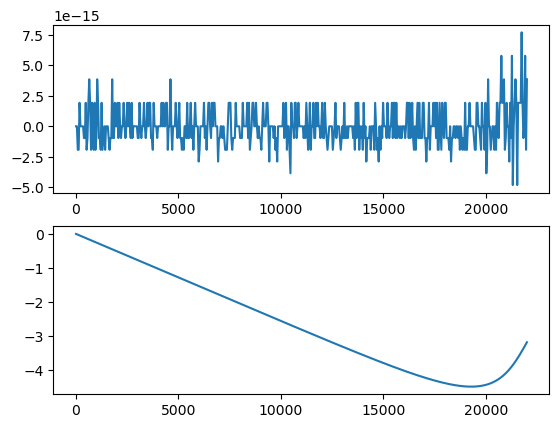

In [7]:
class AllPassIIRDelayFilter(torch.nn.Module):
    def __init__(self,
             FILTERORDER = 3,
             Fs = 44100,
             device = 'cpu',
             ):
        super().__init__()
        self.filterorder= FILTERORDER
        self.Fs = Fs
        self.device = device


    def forward(self, delay: torch.Tensor) -> torch.Tensor:
        '''
        input argument delay is in ms, with batches in axis=0
        
        return taps of all-pass FIR delay filter as a torch tensor B x NTAPS
        '''
        
        if delay.dim() == 0:
            batches = 1
            delay = torch.unsqueeze(delay,dim=0)
        else:
            batches = len(delay)

        n = torch.arange(self.filterorder).to(torch.float32).to(self.device)
        hden = torch.zeros(batches,self.filterorder+1).to(self.device)
        hnum = torch.zeros_like(hden)
        for batch in torch.arange(batches):
            tau = delay[batch]*1e-3*self.Fs
            d = torch.unsqueeze(torch.cumprod((self.filterorder-n)*(self.filterorder-n-tau)/(n+1)/(n+1+tau),dim=-1),dim=0)
            eye = torch.unsqueeze(torch.tensor([1]),dim=0)
            hden[batch,:] = torch.cat((eye,d),dim=1)
            hnum[batch,:] = torch.cat((torch.fliplr(d),eye),dim=1)

        return hnum, hden
    
fractdel = torch.tensor(1/44.1*1.8,device = 'cpu') #milliseconds
print(f"delay samples = {fractdel/1000*44100}")
iirdelayer = AllPassIIRDelayFilter(FILTERORDER=3)
hnum, hden = iirdelayer(fractdel)

fax, Hiirap = scipy.signal.freqz(torch.swapaxes(hnum,0,1).numpy(), a = torch.swapaxes(hden,0,1).numpy(), fs=44100)
plt.subplot(2,1,1)
plt.plot(fax,20*np.log10(np.abs(Hiirap)))
plt.subplot(2,1,2)
plt.plot(fax,np.unwrap(np.angle(Hiirap)))

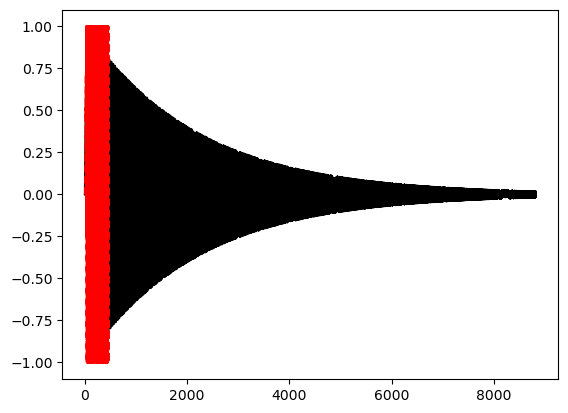

In [41]:
tm = torch.unsqueeze(torch.arange(4410*2)*1/44100,dim=0) #200 ms of audio (8820 samples)
fq = 250 + (8000-250)/200e-3*tm #linear frequency change between 250 Hz and 8000 Hz in 200 milliseconds
sig = torch.exp(-tm/50e-3)*torch.sin(2*torch.pi*fq*tm) 
sigdel = torchaudio.functional.lfilter(sig,hden,hnum)
plt.clf
plt.plot(sig.swapaxes(0,1),'k')
plt.plot(sigdel.swapaxes(0,1),'r--')

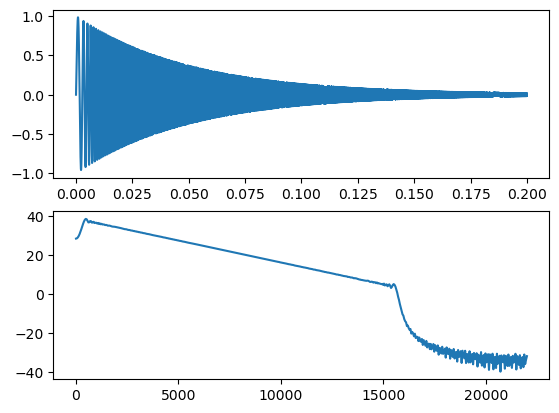

In [42]:
plt.subplot(2,1,1)
plt.plot(tm.swapaxes(0,1),sig.swapaxes(0,1))
fx, Hsig = scipy.signal.freqz(sig.swapaxes(0,1).numpy(),fs=44100)
plt.subplot(2,1,2)
plt.plot(fx,20*np.log10(np.abs(Hsig)))

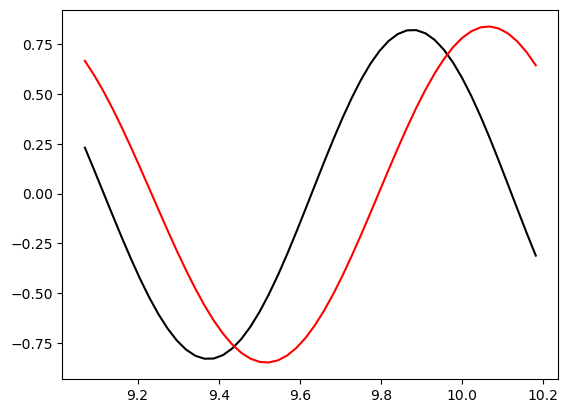

In [45]:
sigdelayed = torchaudio.functional.fftconvolve(sig,fcoefs,mode='same')
plt.plot(tm[0,400:450]*1000,sig[0,400:450],'k',tm[0,400:450]*1000,sigdelayed[0,400:450],'r')

In [33]:
tm[0,:16].numpy(), sig.shape, sigdelayed.shape

(array([0.0000000e+00, 2.2675737e-05, 4.5351473e-05, 6.8027213e-05,
        9.0702946e-05, 1.1337869e-04, 1.3605443e-04, 1.5873015e-04,
        1.8140589e-04, 2.0408163e-04, 2.2675737e-04, 2.4943310e-04,
        2.7210885e-04, 2.9478458e-04, 3.1746030e-04, 3.4013606e-04],
       dtype=float32),
 torch.Size([1, 8820]),
 torch.Size([1, 8820]))

In [24]:
tm.shape

torch.Size([1, 8820])